In [44]:
import pathlib
import random
from matplotlib import pyplot as plt

import h5py
from torch.utils.data import Dataset

from collections import defaultdict

import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
from torch.utils.data import DistributedSampler, DataLoader

from common import evaluate
from common.utils import save_reconstructions


from pytorch_lightning import Trainer
from pytorch_lightning.logging import TestTubeLogger
from torch.nn import functional as F
from torch.optim import RMSprop

from common.args import Args
from common.subsample import create_mask_for_mask_type
from data import transforms

import sys
sys.path.insert(0,'../../common/')
import subsample
import nibabel as nib

from pytorch_lightning.callbacks.early_stopping import EarlyStopping

early_stop_callback = EarlyStopping(
   monitor='val_accuracy',
   min_delta=0.00,
   patience=3,
   verbose=False,
   mode='max'
)

from torch.autograd import Variable
dtype = torch.cuda.FloatTensor

from unet_model import UnetModel


In [33]:
class SliceData_Tanvi(Dataset):
    """
    A PyTorch Dataset that provides access to MR image slices.
    """

    def __init__(self, transform,root,challenge, sample_rate=1):
        """
        Args:
            root (pathlib.Path): Path to the dataset.
            transform (callable): A callable object that pre-processes the raw data into
                appropriate form. The transform function should take 'kspace', 'target',
                'attributes', 'filename', and 'slice' as inputs. 'target' may be null
                for test data.
            challenge (str): "singlecoil" or "multicoil" depending on which challenge to use.
            sample_rate (float, optional): A float between 0 and 1. This controls what fraction
                of the volumes should be loaded.
        """
        self.mask_func = subsample.RandomMaskFunc(center_fractions=[0.08, 0.04], accelerations=[4, 8])
        
        if challenge not in ('singlecoil', 'multicoil'):
            raise ValueError('challenge should be either "singlecoil" or "multicoil"')

        self.transform = transform
        self.recons_key = 'reconstruction_esc' if challenge == 'singlecoil' \
            else 'reconstruction_rss'

        self.examples = []
        files = list(pathlib.Path(root).iterdir())
        
        
        if sample_rate < 1:
            random.shuffle(files)
            num_files = round(len(files) * sample_rate)
            files = files[:num_files]
        for fname in sorted(files):
            
            img = nib.load(fname)
            img_data = img.get_data()
            self.img_data_arr = np.asarray(img_data)
            self.img_data_arr = self.img_data_arr.astype(np.float32)
            img_data_torch = torch.from_numpy(self.img_data_arr)
            self.kspace = np.zeros(img_data_torch.shape,dtype='complex')
            self.kspace = torch.from_numpy(self.kspace)
            for i in range(img_data_torch.shape[2]):
                fft_img = torch.fft.fft2(img_data_torch[:,:,i],norm="ortho")
                self.kspace[:,:,i] = torch.fft.fftshift(fft_img ) 
            #kspace = h5py.File(fname, 'r')['kspace']
            num_slices = self.kspace.shape[2]
            req_slices = np.uint8(num_slices/2)
            #self.masked_kspace, _ = transforms.apply_mask(kspace, self.mask_func)
            self.examples += [(self.kspace[:,:,slice],fname, slice) for slice in range(req_slices-5,req_slices+5)]
        
    
    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        kspace,fname, slice = self.examples[i]
        kspace = kspace.detach().cpu().numpy()
        target = self.img_data_arr[:,:i]
        plt.imshow(20*np.log(np.abs(kspace)),cmap='gray')
        plt.title('K-space')
        plt.figure()
        target = ifft2(transforms.to_tensor(kspace))
        target = complex_abs(target).detach().cpu().numpy()
        plt.imshow(target,cmap='gray')
        plt.title('Ground Truth')
        return self.transform(kspace, target,None, fname, slice)
        
    
    def __getlist__(self):
        return self.examples
    def __getmaskedkspace__(self):
        return self.masked_kspace

In [14]:
def fft(input, signal_ndim, normalized=False):
  # This function is called from the fft2 function below
  if signal_ndim < 1 or signal_ndim > 3:
    print("Signal ndim out of range, was", signal_ndim, "but expected a value between 1 and 3, inclusive")
    return

  dims = (-1)
  if signal_ndim == 2:
    dims = (-2, -1)
  if signal_ndim == 3:
    dims = (-3, -2, -1)

  norm = "backward"
  if normalized:
    norm = "ortho"

  return torch.view_as_real(torch.fft.fftn(torch.view_as_complex(input), dim=dims, norm=norm))

def ifft(input, signal_ndim, normalized=False):
  # This function is called from the ifft2 function below
  if signal_ndim < 1 or signal_ndim > 3:
    print("Signal ndim out of range, was", signal_ndim, "but expected a value between 1 and 3, inclusive")
    return

  dims = (-1)
  if signal_ndim == 2:
    dims = (-2, -1)
  if signal_ndim == 3:
    dims = (-3, -2, -1)

  norm = "backward"
  if normalized:
    norm = "ortho"

  return torch.view_as_real(torch.fft.ifftn(torch.view_as_complex(input), dim=dims, norm=norm))

def fft2(data):
    """
    ref: https://github.com/facebookresearch/fastMRI/tree/master/fastmri
    Apply centered 2 dimensional Fast Fourier Transform. It calls the fft function above to make it compatible with the latest version of pytorch.

    Args:
        data (torch.Tensor): Complex valued input data containing at least 3 dimensions: dimensions
            -3 & -2 are spatial dimensions and dimension -1 has size 2. All other dimensions are
            assumed to be batch dimensions.

    Returns:
        torch.Tensor: The FFT of the input.
    """
    assert data.size(-1) == 2
    data = ifftshift(data, dim=(-3, -2))
    data = fft(data, 2, normalized=True)
    data = fftshift(data, dim=(-3, -2))
    return data


def ifft2(data):
    """
    ref: https://github.com/facebookresearch/fastMRI/tree/master/fastmri
    Apply centered 2-dimensional Inverse Fast Fourier Transform. It calls the ifft function above to make it compatible with the latest version of pytorch.

    Args:
        data (torch.Tensor): Complex valued input data containing at least 3 dimensions: dimensions
            -3 & -2 are spatial dimensions and dimension -1 has size 2. All other dimensions are
            assumed to be batch dimensions.

    Returns:
        torch.Tensor: The IFFT of the input.
    """
    assert data.size(-1) == 2
    data = ifftshift(data, dim=(-3, -2))
    data = ifft(data, 2, normalized=True)
    data = fftshift(data, dim=(-3, -2))
    return data


def complex_abs(data):
    """
    ref: https://github.com/facebookresearch/fastMRI/tree/master/fastmri
    Compute the absolute value of a complex valued input tensor.

    Args:
        data (torch.Tensor): A complex valued tensor, where the size of the final dimension
            should be 2.

    Returns:
        torch.Tensor: Absolute value of data
    """
    assert data.size(-1) == 2
    return (data ** 2).sum(dim=-1).sqrt()

def fftshift(x, dim=None):
    """
    ref: https://github.com/facebookresearch/fastMRI/tree/master/fastmri
    Similar to np.fft.fftshift but applies to PyTorch Tensors
    """
    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [dim // 2 for dim in x.shape]
    elif isinstance(dim, int):
        shift = x.shape[dim] // 2
    else:
        shift = [x.shape[i] // 2 for i in dim]
    return roll(x, shift, dim)


def ifftshift(x, dim=None):
    """
    ref: https://github.com/facebookresearch/fastMRI/tree/master/fastmri
    Similar to np.fft.ifftshift but applies to PyTorch Tensors
    """
    if dim is None:
        dim = tuple(range(x.dim()))
        shift = [(dim + 1) // 2 for dim in x.shape]
    elif isinstance(dim, int):
        shift = (x.shape[dim] + 1) // 2
    else:
        shift = [(x.shape[i] + 1) // 2 for i in dim]
    return roll(x, shift, dim)

def roll(x, shift, dim):
    """
    ref: https://github.com/facebookresearch/fastMRI/tree/master/fastmri
    Similar to np.roll but applies to PyTorch Tensors
    """
    if isinstance(shift, (tuple, list)):
        assert len(shift) == len(dim)
        for s, d in zip(shift, dim):
            x = roll(x, s, d)
        return x
    shift = shift % x.size(dim)
    if shift == 0:
        return x
    left = x.narrow(dim, 0, x.size(dim) - shift)
    right = x.narrow(dim, x.size(dim) - shift, shift)
    return torch.cat((right, left), dim=dim)


In [15]:
class DataTransform_Tanvi:
    """
    Data Transformer for training U-Net models.
    """

    def __init__(self, resolution, which_challenge, mask_func=None, use_seed=True):
        """
        Args:
            mask_func (common.subsample.MaskFunc): A function that can create a mask of
                appropriate shape.
            resolution (int): Resolution of the image.
            which_challenge (str): Either "singlecoil" or "multicoil" denoting the dataset.
            use_seed (bool): If true, this class computes a pseudo random number generator seed
                from the filename. This ensures that the same mask is used for all the slices of
                a given volume every time.
        """
        if which_challenge not in ('singlecoil', 'multicoil'):
            raise ValueError(f'Challenge should either be "singlecoil" or "multicoil"')
        self.mask_func = mask_func
        self.resolution = resolution
        self.which_challenge = which_challenge
        self.use_seed = use_seed

    def __call__(self, kspace, target, attrs, fname, slice):
        """
        Args:
            kspace (numpy.array): Input k-space of shape (num_coils, rows, cols, 2) for multi-coil
                data or (rows, cols, 2) for single coil data.
            target (numpy.array): Target image
            attrs (dict): Acquisition related information stored in the HDF5 object.
            fname (str): File name
            slice (int): Serial number of the slice.
        Returns:
            (tuple): tuple containing:
                image (torch.Tensor): Zero-filled input image.
                target (torch.Tensor): Target image converted to a torch Tensor.
                mean (float): Mean value used for normalization.
                std (float): Standard deviation value used for normalization.
        """
        kspace = transforms.to_tensor(kspace)
        # Apply mask
        if self.mask_func:
            seed = None if not self.use_seed else tuple(map(ord, fname))
            masked_kspace, mask = transforms.apply_mask(kspace, self.mask_func, seed)
        else:
            masked_kspace = kspace
        
        #print(masked_kspace.shape)
        # Inverse Fourier Transform to get zero filled solution
        image = ifft2(masked_kspace)
        # Crop input image to given resolution if larger
        smallest_width = min(self.resolution, image.shape[-2])
        smallest_height = min(self.resolution, image.shape[-3])
        if target is not None:
            smallest_width = min(smallest_width, target.shape[-1])
            smallest_height = min(smallest_height, target.shape[-2])
        crop_size = (smallest_height, smallest_width)
        image = transforms.complex_center_crop(image, crop_size)
        # Absolute value
        image = transforms.complex_abs(image)
        # Apply Root-Sum-of-Squares if multicoil data
        if self.which_challenge == 'multicoil':
            image = transforms.root_sum_of_squares(image)
        # Normalize input
        image, mean, std = transforms.normalize_instance(image, eps=1e-11)
        image = image.clamp(-6, 6)
        # Normalize target
        if target is not None:
            target = transforms.to_tensor(target)
            target = transforms.center_crop(target, crop_size)
            target = transforms.normalize(target, mean, std, eps=1e-11)
            target = target.clamp(-6, 6)
        else:
            target = torch.Tensor([0])
        return image, target, mean, std, fname, slice


In [41]:
class MRIModel_Tanvi(pl.LightningModule):
    """
    Abstract super class for Deep Learning based reconstruction models.
    This is a subclass of the LightningModule class from pytorch_lightning, with
    some additional functionality specific to fastMRI:
        - fastMRI data loaders
        - Evaluating reconstructions
        - Visualization
        - Saving test reconstructions

    To implement a new reconstruction model, inherit from this class and implement the
    following methods:
        - train_data_transform, val_data_transform, test_data_transform:
            Create and return data transformer objects for each data split
        - training_step, validation_step, test_step:
            Define what happens in one step of training, validation and testing respectively
        - configure_optimizers:
            Create and return the optimizers
    Other methods from LightningModule can be overridden as needed.
    """

    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams

    def _create_data_loader(self, data_transform, data_partition, sample_rate=None):
        sample_rate = sample_rate or self.hparams.sample_rate
        dataset = SliceData_Tanvi(
            root=self.hparams.data_path / f'{self.hparams.challenge}_{data_partition}',
            transform=data_transform,
            sample_rate=sample_rate,
            challenge=self.hparams.challenge
        )
        sampler = DistributedSampler(dataset)
        return DataLoader(
            dataset=dataset,
            batch_size=self.hparams.batch_size,
            num_workers=1,
            pin_memory=True,
            sampler=sampler,
        )

    def train_data_transform(self):
        raise NotImplementedError

    
    def train_dataloader(self):
        return self._create_data_loader(self.train_data_transform(), data_partition='train')

    def val_data_transform(self):
        raise NotImplementedError

    
    def val_dataloader(self):
        return self._create_data_loader(self.val_data_transform(), data_partition='val')

    def test_data_transform(self):
        raise NotImplementedError

    
    def test_dataloader(self):
        return self._create_data_loader(self.test_data_transform(), data_partition='test', sample_rate=1.)

    def _evaluate(self, val_logs):
        losses = []
        outputs = defaultdict(list)
        targets = defaultdict(list)
        for log in val_logs:
            losses.append(log['val_loss'].cpu().numpy())
            for i, (fname, slice) in enumerate(zip(log['fname'], log['slice'])):
                outputs[fname].append((slice, log['output'][i]))
                targets[fname].append((slice, log['target'][i]))
        metrics = dict(val_loss=losses, nmse=[], ssim=[], psnr=[])
        for fname in outputs:
            output = np.stack([out for _, out in sorted(outputs[fname])])
            target = np.stack([tgt for _, tgt in sorted(targets[fname])])
            metrics['nmse'].append(evaluate.nmse(target, output))
            metrics['ssim'].append(evaluate.ssim(target, output))
            metrics['psnr'].append(evaluate.psnr(target, output))
        metrics = {metric: np.mean(values) for metric, values in metrics.items()}
        print(metrics, '\n')
        return dict(log=metrics, **metrics)

    def _visualize(self, val_logs):
        def _normalize(image):
            image = image[np.newaxis]
            image -= image.min()
            return image / image.max()

        def _save_image(image, tag):
            grid = torchvision.utils.make_grid(torch.Tensor(image), nrow=4, pad_value=1)
            self.logger.experiment.add_image(tag, grid)

        # Only process first size to simplify visualization.
        visualize_size = val_logs[0]['output'].shape
        val_logs = [x for x in val_logs if x['output'].shape == visualize_size]
        num_logs = len(val_logs)
        num_viz_images = 16
        step = (num_logs + num_viz_images - 1) // num_viz_images
        outputs, targets = [], []
        for i in range(0, num_logs, step):
            outputs.append(_normalize(val_logs[i]['output'][0]))
            targets.append(_normalize(val_logs[i]['target'][0]))
        outputs = np.stack(outputs)
        targets = np.stack(targets)
        _save_image(targets, 'Target')
        _save_image(outputs, 'Reconstruction')
        _save_image(np.abs(targets - outputs), 'Error')

    def validation_end(self, val_logs):
        self._visualize(val_logs)
        return self._evaluate(val_logs)

    def test_end(self, test_logs):
        outputs = defaultdict(list)
        for log in test_logs:
            for i, (fname, slice) in enumerate(zip(log['fname'], log['slice'])):
                outputs[fname].append((slice, log['output'][i]))
        for fname in outputs:
            outputs[fname] = np.stack([out for _, out in sorted(outputs[fname])])
        save_reconstructions(outputs, self.hparams.exp_dir / self.hparams.exp / 'reconstructions')
        return dict()


In [51]:
class UnetMRIModel_Tanvi(MRIModel_Tanvi):
    def __init__(self, hparams):
        super().__init__(hparams)
        self.unet = UnetModel(
            in_chans=1,
            out_chans=1,
            chans=hparams.num_chans,
            num_pool_layers=hparams.num_pools,
            drop_prob=hparams.drop_prob
        )

    def forward(self, input):
        return self.unet(input.unsqueeze(1)).squeeze(1)

    def training_step(self, batch, batch_idx):
        input, target, mean, std, _, _ = batch
        output = self.forward(input)
        loss = F.l1_loss(output, target)
        logs = {'loss': loss.item()}
        return dict(loss=loss, log=logs)

    def validation_step(self, batch, batch_idx):
        input, target, mean, std, fname, slice = batch
        output = self.forward(input)
        mean = mean.unsqueeze(1).unsqueeze(2)
        std = std.unsqueeze(1).unsqueeze(2)
        return {
            'fname': fname,
            'slice': slice,
            'output': (output * std + mean).cpu().numpy(),
            'target': (target * std + mean).cpu().numpy(),
            'val_loss': F.l1_loss(output, target),
        }

    def test_step(self, batch, batch_idx):
        input, _, mean, std, fname, slice = batch
        output = self.forward(input)
        mean = mean.unsqueeze(1).unsqueeze(2)
        std = std.unsqueeze(1).unsqueeze(2)
        return {
            'fname': fname,
            'slice': slice,
            'output': (output * std + mean).cpu().numpy(),
        }

    def configure_optimizers(self):
        optim = RMSprop(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optim, self.hparams.lr_step_size, self.hparams.lr_gamma)
        return [optim], [scheduler]

    def train_data_transform(self):
        mask = create_mask_for_mask_type(self.hparams.mask_type, self.hparams.center_fractions,
                                         self.hparams.accelerations)
        return DataTransform(self.hparams.resolution, self.hparams.challenge, mask, use_seed=False)

    def val_data_transform(self):
        mask = create_mask_for_mask_type(self.hparams.mask_type, self.hparams.center_fractions,
                                         self.hparams.accelerations)
        return DataTransform(self.hparams.resolution, self.hparams.challenge, mask)

    def test_data_transform(self):
        return DataTransform(self.hparams.resolution, self.hparams.challenge)


In [45]:
def create_trainer(args, logger):
    return Trainer(
        #num_nodes=1,
        logger=logger,
        default_root_dir=args.exp_dir,
        checkpoint_callback=True,
        max_epochs=args.num_epochs,
        gpus=args.gpus,
        distributed_backend='ddp',
        check_val_every_n_epoch=1,
        val_check_interval=1.,
        callbacks=[early_stop_callback]
        )

In [58]:
class Args():
    def __init__(self,mode,challenge,data_path,exp_dir,exp,mask_type,num_epochs,gpus,action='store_true'):
        self.mode=mode
        self.num_epochs=num_epochs
        self.gpus=gpus
        self.exp = exp
        self.data_path = data_path
        self.exp_dir=exp_dir
        self.seed = 42
        self.challenge = challenge
        self.mask_type = mask_type
        self.num_pools = 4
        self.drop_prob = 0
        self.num_chans = 32
        self.weight_decay = 0.
        self.lr = 0.001 
        self.lr_gamma = 0.1
        self.lr_step_size = 40 
        self.center_fractions = [0.08, 0.04]
        self.accelerations = [4, 8]
        self.resolution = 256
        self.batch_size = 16

In [35]:
s = SliceData_Tanvi(data_transform_cs,data_path, 'singlecoil')
#data = (s.__getlist__())

<ipython-input-33-cf4004dafc7e>:38: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img_data = img.get_data()


torch.Size([256, 256, 2])


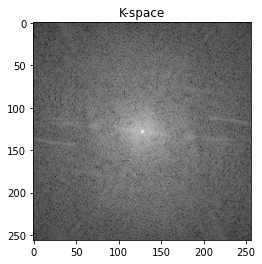

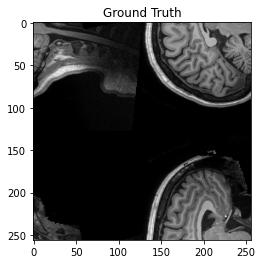

In [36]:
image, target, mean, std, fname, slice = s.__getitem__(20)

Text(0.5, 1.0, 'UnderSampled Image')

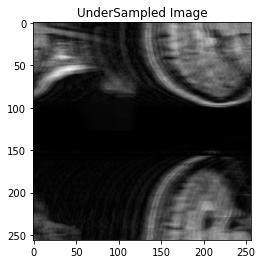

In [37]:
plt.imshow(image,cmap='gray')
plt.title('UnderSampled Image')

In [46]:
import random 
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
load_version = None
logger = TestTubeLogger(save_dir=args.exp_dir, name=args.exp, version=load_version)
trainer = create_trainer(args, logger)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


In [53]:
trainer.fit(umdl)

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `test_dataloader()` and have defined a `test_step()`, you may also want to define `test_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)


PicklingError: Can't pickle <class '__main__.Args'>: it's not the same object as __main__.Args

In [50]:
top_me = MRIModel_Tanvi(args)

TypeError: Can't instantiate abstract class MRIModel_Tanvi with abstract methods forward

In [65]:
if __name__ == '__main__':
    data_path = 'C:/Users/user/Desktop/MS_Sem2/ML/ML Project/train_Tanvi'
    out_path = './experiments'        
    args = Args(mode='train',challenge='singlecoil',data_path=data_path,exp_dir=out_path,exp='unet',
                mask_type='equispaced',num_epochs=50,gpus=1)
    mask_func = subsample.RandomMaskFunc(center_fractions=args.center_fractions,
                                         accelerations=args.accelerations)
    data_transform_cs = DataTransform_Tanvi(args.resolution,args.challenge,
                                            mask_func=mask_func, use_seed=False)
     
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    load_version = None
    logger = TestTubeLogger(save_dir=args.exp_dir, name=args.exp, version=load_version)
    trainer = create_trainer(args, logger)
    umdl = UnetMRIModel_Tanvi(args)
    trainer.fit(umdl)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


ProcessExitedException: process 0 terminated with exit code 1

In [66]:
def _create_data_loader_tanvi(data_transform,sample_rate=1):
        sample_rate = sample_rate 
        dataset = SliceData_Tanvi(
            root=args.data_path,
            transform=data_transform,
            sample_rate=sample_rate,
            challenge=args.challenge
        )
        sampler = DistributedSampler(dataset)
        return DataLoader(
            dataset=dataset,
            batch_size=args.batch_size,
            num_workers=1,
            pin_memory=True,
            sampler=sampler,
        )

In [68]:
train_dataloader = _create_data_loader_tanvi(DataTransform_Tanvi)

<ipython-input-33-cf4004dafc7e>:38: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  img_data = img.get_data()


RuntimeError: Default process group has not been initialized, please make sure to call init_process_group.